In [1]:
import requests
from io import BytesIO
from zipfile import ZipFile

In [2]:
import pandas as pd

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Задание 1
# Переберите параметры с помощью GridSearchCV и обучите Random Forest на данных о грибах
# Передайте в GridSearchCV модель с указанием random_state
# RandomForestClassifier(random_state=0)
# Параметры для выбора:
# - n_estimators: от 10 до 50 с шагом 10
# - max_depth: от 1 до 12 с шагом 2
# - min_samples_leaf: от 1 до 7
# - min_samples_split: от 2 до 9 с шагом 2
# Укажите cv=3. Для ускорения расчётов в GridSearchCV можно указать n_jobs=-1, чтобы использовать все процессоры.
# Какие параметры Random Forest были отобраны как наилучшие для решения на этих данных?

In [6]:
# Данные которые будут использоваться для решения задач
mushrooms_train_df = pd.read_csv("https://stepik.org/media/attachments/course/4852/training_mush.csv")
mushrooms_train_df

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,2,0,3,1,5,1,0,0,9,1,...,3,7,0,2,1,4,3,5,0,0
1,2,0,4,0,5,1,0,1,10,0,...,7,4,0,2,1,0,7,4,0,1
2,2,0,3,0,2,1,0,0,7,0,...,0,4,0,2,1,2,1,5,1,1
3,0,0,3,0,5,1,1,0,2,0,...,7,7,0,2,2,4,7,3,1,0
4,2,3,3,1,5,1,0,0,10,1,...,3,6,0,2,1,4,2,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6088,2,0,3,0,5,1,1,0,4,1,...,7,7,0,2,1,0,3,3,1,0
6089,3,2,2,0,2,1,0,1,0,1,...,6,7,0,2,1,0,7,4,0,1
6090,5,2,3,0,1,1,0,1,9,0,...,7,7,0,2,1,4,3,4,0,1
6091,3,2,3,0,5,1,1,0,2,0,...,7,7,0,2,2,4,7,3,1,0


In [7]:
# Опрелелим тренировочные данные: разделим признаки (фичи и целевые значения)
X_train = mushrooms_train_df.drop("class", axis=1)
y_train = mushrooms_train_df["class"]

# Определим параметры, из которых найдем лучший набор
mushrooms_params = {
    "n_estimators": range(10, 50, 10),
    "max_depth": range(1, 12, 2),
    "min_samples_leaf": range(1, 7),
    "min_samples_split": range(2, 9, 2),
}

# Определим и обучим наш RandomForrest и подберем лучше параметры
rf = RandomForestClassifier(random_state=0)
clf_grid = GridSearchCV(rf, mushrooms_params, cv=3, n_jobs=-1)
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': range(1, 12, 2),
                         'min_samples_leaf': range(1, 7),
                         'min_samples_split': range(2, 9, 2),
                         'n_estimators': range(10, 50, 10)})

In [8]:
# Лучшие параметры:
clf_grid.best_params_

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [9]:
# Определим лучшую модель
rf_clf = clf_grid.best_estimator_
rf_clf

RandomForestClassifier(max_depth=9, n_estimators=10, random_state=0)

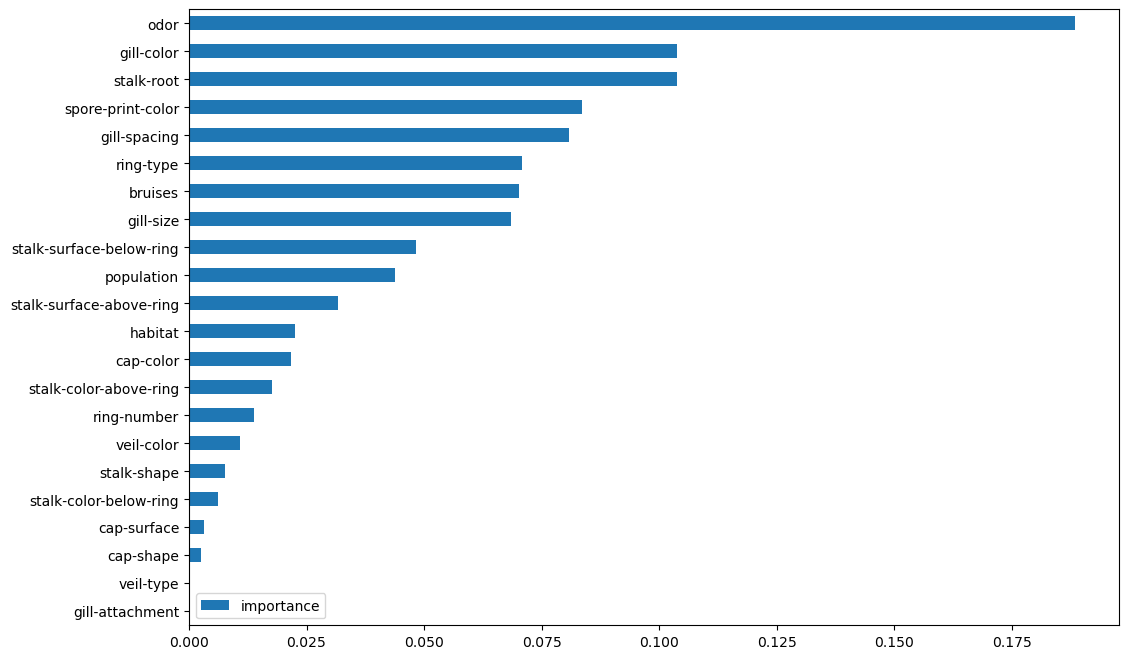

In [10]:
# Построим полученную модель
imp = pd.DataFrame(rf_clf.feature_importances_, index=X_train.columns, columns=["importance"])
imp.sort_values("importance").plot(kind="barh", figsize=(12, 8))
plt.show()

In [11]:
# Задание 2
# Теперь у нас есть классификатор, определяющий какие грибы съедобные, а какие нет, испробуем его!
# Предскажите съедобность этих данных грибов и напишите в ответ число несъедобных грибов (класс равен 1).
# Заметьте, что для использования этого леса на новых грибах, нам нужно будет заполнить значения параметров гриба,
# часть из которых определить проще (например, цвет шляпки), а для определения части понадобится специалист-миколог.
# То есть в этом случае нам придётся самим экстрагировать признаки из объекта.
# Для зрительных признаков типа формы, цвета можно использовать более сложную модель (например, свёрточную нейронную сеть)
# и подавать на вход фотки гриба. И модель сама извлечёт признаки вместо того, чтобы нам описывать самим.
# Но одной фоткой тут не отделаешься - для определения запаха понадобится ещё детектор

In [12]:
# Выгрузим тестовые данные
X_test = pd.read_csv("https://stepik.org/media/attachments/course/4852/testing_mush.csv")
X_test.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,3,8,1,3,1,0,0,4,0,...,2,7,7,0,2,1,4,2,3,3
1,5,3,4,1,5,1,0,0,10,1,...,2,6,6,0,2,1,4,3,5,0
2,3,3,4,0,8,1,0,1,0,1,...,2,7,6,0,2,1,0,7,4,4
3,3,2,2,0,7,1,0,1,0,1,...,1,6,7,0,2,1,0,7,4,0
4,3,2,2,0,8,1,0,1,0,1,...,1,6,6,0,2,1,0,7,4,4


In [13]:
# Предсказание на тестовых данных с записью результата в формате pd.Series
y_pred = pd.Series(rf_clf.predict(X_test), name="class")
y_pred

0       0
1       0
2       1
3       1
4       1
       ..
2026    1
2027    0
2028    1
2029    0
2030    1
Name: class, Length: 2031, dtype: int64

In [14]:
# Посчитаем количество несъедобных грибов
edible, non_edible = y_pred.value_counts()
edible, non_edible

(1055, 976)

In [15]:
# Задание 3
# Создайте confusion matrix по предсказаниям, полученным вами в прошлом уроке и правильным ответам,
# (воспользуйтесь паролем из предыдущего задания, чтобы открыть их).

In [16]:
# Загружаем и распаковываем архив с целевыми значениями для тестовых данных
response = requests.get("https://stepik.org/media/attachments/course/4852/testing_y_mush.csv.zip")
zip_file = ZipFile(BytesIO(response.content))

csv_file = 'testing_y_mush.csv'  # Имя извлекаемого из архива файла
password = 'Cool!Move_forward!'  # Пароль полученный в предыдущем задании
with zip_file.open(csv_file, pwd=password.encode('utf-8')) as file:
    y_true = pd.read_csv(file)

y_true.head()

,class
0,0
1,0
2,1
3,1
4,1


In [17]:
# Создадим Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[1055,    0],
       [   0,  976]])

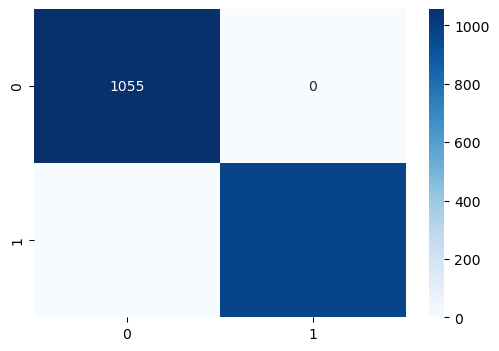

In [18]:
# Построим Confusion Matrix с использованием библиотеки seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.show()

In [19]:
# Задание 4
# Перейдём к следующему датасэту.
# На Землю нападают войска жукеров, и в их флоте присутствуют транспортники, истребители и крейсеры.
# Для борьбы с каждым типом кораблей используется свой вид оружия.
# Как аналитику из Штаба Обороны, вам поручено разработать модель, предсказывающую какие корабли участвуют в атаке,
# чтобы успешно отбить нападения на различные области планеты
# Данных удалось собрать немного, и предсказывать придётся гораздо больший по объёму массив.
# Обучите модель и предскажите классы кораблей для новых поступающих данных.
# Укажите в ответе через пробел число крейсеров, транспортников и истребителей.
# От вашего ответа зависит судьба человечества!

In [20]:
# Загрузим тренировочные данные
invasion_train_df = pd.read_csv("https://stepik.org/media/attachments/course/4852/invasion.csv")
invasion_train_df

,class,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
0,transport,2.190672,6.716633,62.168208,0.347465,158221,44.932446
1,transport,3.453276,8.995909,62.994707,0.590094,385972,41.568300
2,transport,2.432994,6.938691,62.245807,0.329288,446482,40.123467
3,fighter,6.083763,3.019459,18.474555,0.174738,210125,11.384865
4,fighter,12.876769,2.452950,195.805771,0.150446,23109,11.328806
...,...,...,...,...,...,...,...
495,fighter,9.901731,7.162124,58.095069,0.145065,395762,12.901909
496,transport,3.574132,7.118835,62.928159,0.469670,435926,39.926551
497,fighter,9.186049,4.580781,412.102112,0.108195,299594,12.178203
498,fighter,8.278256,8.353756,268.121561,0.132661,361911,13.905809


In [21]:
# Загрузим тестовые данные
X_test = pd.read_csv("https://stepik.org/media/attachments/course/4852/operative_information.csv")
X_test.head()

,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
0,7.516543,3.916691,513.954279,0.177247,105908,13.267224
1,4.322988,6.967689,63.752970,0.545922,277855,39.833130
2,4.595724,9.098297,62.233948,0.389201,160662,42.014556
3,2.689675,7.964869,62.475495,0.541081,162092,42.056829
4,8.075576,5.169719,336.441261,0.174757,466853,11.779813


In [22]:
# Определим массивы признакеов и целевых значений для тренировочных данных
X_train = invasion_train_df.drop("class", axis=1)
y_train = invasion_train_df["class"]

# Созданим и обучим модель RandomForest
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [23]:
# Предскажем значения для тестовых данных и посчитаем колабли
y_pred = pd.Series(rf_clf.predict(X_test), name='class')
y_pred.value_counts()

class
fighter      675
transport    595
cruiser      230
Name: count, dtype: int64

In [24]:
# Задание 5
# Какая переменная оказалась самой важной для классифицирования кораблей?

In [25]:
# Определим датасет для чис и отсортируем его по важности
features_df = pd.DataFrame({"features_names": rf_clf.feature_names_in_, "importance": rf_clf.feature_importances_})
features_df.sort_values("importance", ascending=False)

,features_names,importance
5,volume,0.323855
3,brightness,0.278944
0,g_reflection,0.185294
2,speed,0.117529
1,i_reflection,0.093694
4,time_of_observance,0.000685


In [26]:
# Задание 6
# Благодаря вашим стараниям войска захватчиков были разгромлены, но война ещё не окончена!
# Вас повысили и перевели на новое направление (новые должности - новые задачи).
# Теперь нужно выявлять опасные регионы космоса, где могут находиться жукеры.
# Проанализируйте имеющиеся данные об опасности разных регионов космоса и укажите наиболее вероятные причины угрозы

In [27]:
# Загрузим данные об опасности космоса
danger_df = pd.read_csv("https://stepik.org/media/attachments/course/4852/space_can_be_a_dangerous_place.csv")
danger_df.head()

,r,phi,peradventure_index,dustiness,black_hole_is_near,buggers_were_noticed,nearby_system_has_planemo,dangerous
0,169.1,138.0,22.3212,0.706285,0,1,1,1
1,11.1,148.0,1.4652,-0.410512,1,1,1,1
2,274.6,201.0,36.2472,0.756457,1,1,1,1
3,172.8,173.0,22.8096,0.035221,1,1,1,1
4,223.3,222.0,29.4756,0.197271,0,1,1,1


In [28]:
# Подготовим тренировочные данные
X_train = danger_df.drop(["dangerous"], axis = 1)
y_train = danger_df["dangerous"]

# Обучим новую модель RandomForest
rf = RandomForestClassifier(random_state=0, max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

<Axes: ylabel='features'>

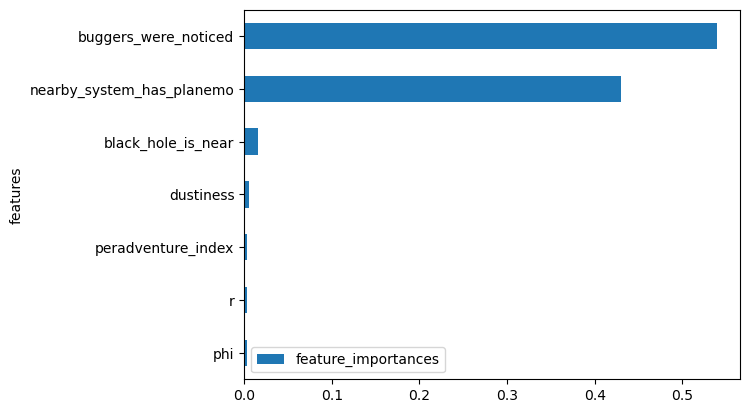

In [29]:
# Построим гистограмму фич и посмотрим на их влияние
imp = pd.DataFrame({'features':list(X_train), 'feature_importances': rf.feature_importances_})
imp.sort_values('feature_importances', ascending=True).plot.barh(x='features')